<a href="https://colab.research.google.com/github/srivatsa-bot/Ai_Research/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 96% 78.0M/80.9M [00:04<00:00, 24.4MB/s]
100% 80.9M/80.9M [00:04<00:00, 18.8MB/s]
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
#final bilstm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
# Import Tokenizer from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, InputLayer
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
class PreprocessingComparison:
    def __init__(self, max_vocab=50000, max_length=20, embedding_dim=100):
        self.max_vocab = max_vocab
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # Set memory growth for GPU
        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, True)

    def load_data(self, data_path):
        """Load and prepare the Sentiment140 dataset"""
        df = pd.read_csv(data_path,
                        names=['target', 'id', 'date', 'flag', 'user', 'text'],
                        encoding="ISO-8859-1")
        X = np.array(df['text'])
        Y = np.array(df['target'])
        Y[Y == 4] = 1  # Convert target 4 to 1 for positive sentiment
        return X, Y

    def preprocess_no_processing(self, texts):
        """No preprocessing, just lowercase"""
        return [text.lower() for text in texts]

    def preprocess_stopwords_only(self, texts):
        """Remove stopwords only"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [token for token in tokens if token not in self.stop_words]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def preprocess_lemmatization_only(self, texts):
        """Apply lemmatization only"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def preprocess_full(self, texts):
        """Apply both stopword removal and lemmatization"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [self.lemmatizer.lemmatize(token)
                     for token in tokens if token not in self.stop_words]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def prepare_sequences(self, texts, tokenizer=None):
        """Convert text to padded sequences"""
        if tokenizer is None:
            tokenizer = Tokenizer(num_words=self.max_vocab, filters='@')
            tokenizer.fit_on_texts(texts)

        sequences = tokenizer.texts_to_sequences(texts)
        padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
            sequences,
            maxlen=self.max_length,
            padding='pre',
            truncating='pre'
        )
        return padded_sequences, tokenizer

    def build_model(self):
        """Build bilstm LSTM model with GPU compatibility"""
        model = Sequential([
            InputLayer(input_shape=(self.max_length,)),
            Embedding(self.max_vocab, self.embedding_dim, input_length=self.max_length),
            Bidirectional(LSTM(64, return_sequences=False, unroll=True)),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        # Use mixed precision for better GPU performance
        tf.keras.mixed_precision.set_global_policy('mixed_float16')

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def train_and_evaluate(self, X_train, X_test, y_train, y_test, preprocessing_name):
        """Train model and evaluate performance"""
        # Convert labels to float32 for GPU compatibility
        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')

        # Create training and validation datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
            .shuffle(10000)\
            .batch(1024)

        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
            .batch(1024)

        model = self.build_model()

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        history = model.fit(
            train_dataset,
            epochs=5,
            validation_data=test_dataset,
            callbacks=[early_stopping],
            verbose=1
        )

        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

        # Calculate F1 score
        y_pred_prob = model.predict(test_dataset)
        y_pred = (y_pred_prob > 0.5).astype("int32")

        f1 = f1_score(y_test, y_pred)

        return history.history, test_loss, test_accuracy, f1


    def compare_preprocessing_methods(self, X, y):
        """Compare different preprocessing methods"""
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        results = {}

        preprocessing_methods = {
            'No Processing': self.preprocess_no_processing,
            'Stopwords Only': self.preprocess_stopwords_only,
            'Lemmatization Only': self.preprocess_lemmatization_only,
            'Full Preprocessing': self.preprocess_full
        }

        histories = {}
        for name, method in preprocessing_methods.items():
            print(f"\nTraining model with {name}")

            X_train_processed = method(X_train_raw)
            X_test_processed = method(X_test_raw)

            X_train_seq, tokenizer = self.prepare_sequences(X_train_processed)
            X_test_seq, _ = self.prepare_sequences(X_test_processed, tokenizer)

            history, test_loss, test_accuracy, f1_score_val = self.train_and_evaluate(
                X_train_seq, X_test_seq, y_train, y_test, name
            )

            results[name] = {
                'Test Loss': test_loss,
                'Test Accuracy': test_accuracy,
                'F1 Score': f1_score_val,
                'History': history
            }

        return results



    def plot_results(self, results):
        """Plot comparison results with separate figures for each visualization"""
        methods = list(results.keys())

        # Figure 1: Test Accuracy
        plt.figure(figsize=(12, 6))
        accuracies = [results[method]['Test Accuracy'] for method in methods]
        bars = plt.bar(methods, accuracies, color='skyblue')
        plt.title('Test Accuracy by Preprocessing Method')
        plt.xticks(rotation=45)
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                    f'{accuracy:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Figure 2: F1 Scores
        plt.figure(figsize=(12, 6))
        f1_scores = [results[method]['F1 Score'] for method in methods]
        bars = plt.bar(methods, f1_scores, color='lightcoral')
        plt.title('F1 Score by Preprocessing Method')
        plt.xticks(rotation=45)
        plt.ylabel('F1 Score')
        plt.grid(True, linestyle='--', alpha=0.7)
        for bar, f1_score in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                    f'{f1_score:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Figure 3: Training Loss
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['loss'], label=f'{method} - Training Loss')
        plt.title('Training Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 4: Validation Loss
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['val_loss'],
                    label=f'{method} - Validation Loss')
        plt.title('Validation Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 5: Training Accuracy
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['accuracy'],
                    label=f'{method} - Training Accuracy')
        plt.title('Training Accuracy During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 6: Validation Accuracy
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['val_accuracy'],
                    label=f'{method} - Validation Accuracy')
        plt.title('Validation Accuracy During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\nDetailed Results:")
        print("-" * 50)
        for method, metrics in results.items():
            print(f"{method:20s}: Test Accuracy: {metrics['Test Accuracy']:.4f}")


if __name__ == "__main__":
    comparison = PreprocessingComparison()
    X, y = comparison.load_data("training.1600000.processed.noemoticon.csv")
    results = comparison.compare_preprocessing_methods(X, y)
    comparison.plot_results(results)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Training model with No Processing


KeyboardInterrupt: 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Training model with No Processing


Processing with no_processing: 100%|██████████| 8/8 [00:33<00:00,  4.22s/it]
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 26ms/step - accuracy: 0.7629 - loss: 0.4977 - val_accuracy: 0.8089 - val_loss: 0.4329
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8135 - loss: 0.4264 - val_accuracy: 0.8153 - val_loss: 0.4236
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8235 - loss: 0.4100 - val_accuracy: 0.8180 - val_loss: 0.4201
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8318 - loss: 0.3959 - val_accuracy: 0.8160 - val_loss: 0.4272
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.8421 - loss: 0.3808 - val_accuracy: 0.8133 - val_loss: 0.4390
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step

Training model with Stopwords Only


Processing with stopwords_only: 100%|██████████| 8/8 [00:35<00:00,  4.42s/it]


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 16ms/step - accuracy: 0.7468 - loss: 0.5211 - val_accuracy: 0.7902 - val_loss: 0.4658
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7925 - loss: 0.4593 - val_accuracy: 0.7943 - val_loss: 0.4584
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8015 - loss: 0.4456 - val_accuracy: 0.7958 - val_loss: 0.4580
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8103 - loss: 0.4329 - val_accuracy: 0.7946 - val_loss: 0.4667
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8212 - loss: 0.4171 - val_accuracy: 0.7922 - val_loss: 0.4820
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step

Training model with Lemmatization Only


Processing with lemmatization_only: 100%|██████████| 8/8 [00:44<00:00,  5.56s/it]


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 17ms/step - accuracy: 0.7626 - loss: 0.4976 - val_accuracy: 0.8083 - val_loss: 0.4335
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.8128 - loss: 0.4273 - val_accuracy: 0.8154 - val_loss: 0.4232
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8226 - loss: 0.4110 - val_accuracy: 0.8175 - val_loss: 0.4211
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8306 - loss: 0.3978 - val_accuracy: 0.8175 - val_loss: 0.4251
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.8401 - loss: 0.3832 - val_accuracy: 0.8166 - val_loss: 0.4368
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step

Training model with Full Preprocessing


Processing with full: 100%|██████████| 8/8 [00:41<00:00,  5.17s/it]


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.7483 - loss: 0.5195 - val_accuracy: 0.7886 - val_loss: 0.4659
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.7914 - loss: 0.4607 - val_accuracy: 0.7921 - val_loss: 0.4626
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7991 - loss: 0.4484 - val_accuracy: 0.7961 - val_loss: 0.4570
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8079 - loss: 0.4353 - val_accuracy: 0.7962 - val_loss: 0.4632
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8185 - loss: 0.4201 - val_accuracy: 0.7916 - val_loss: 0.4770
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step


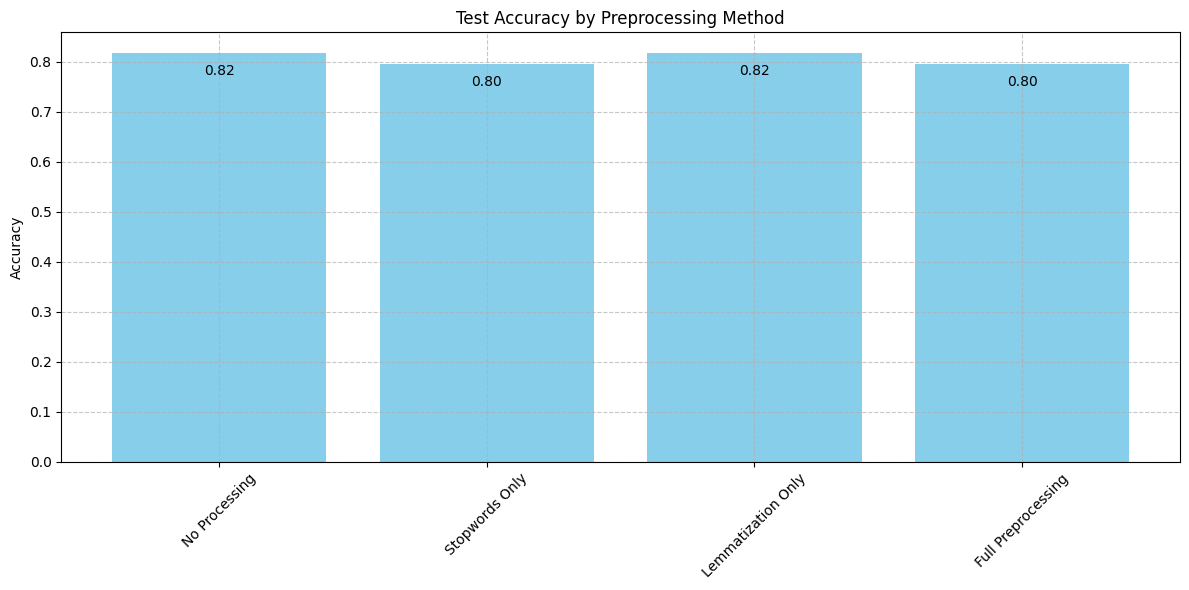

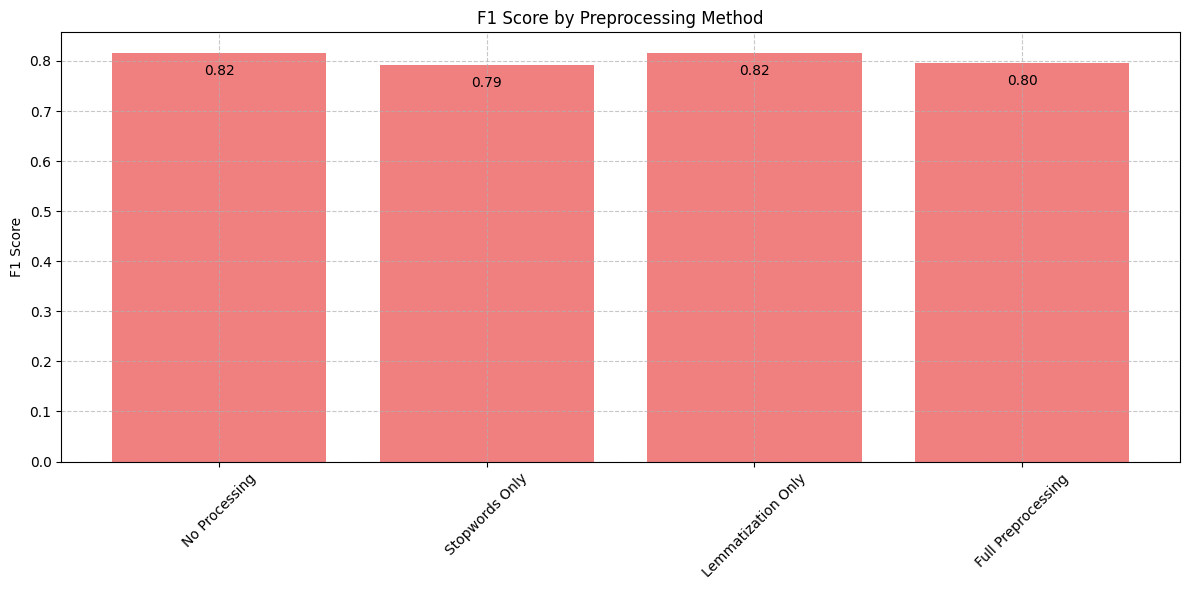

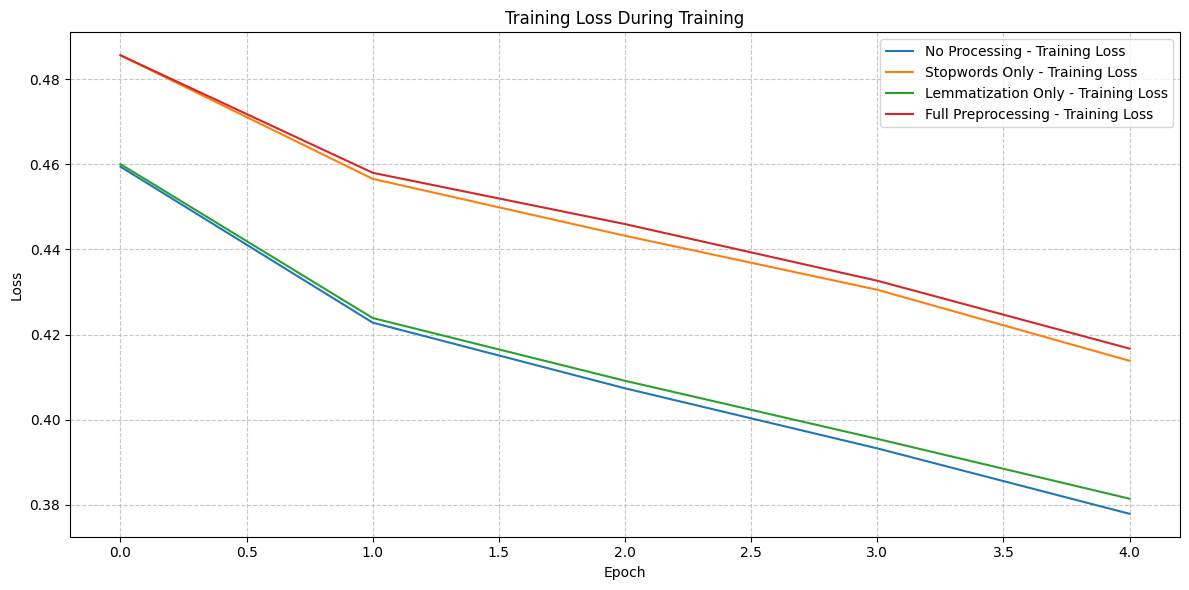

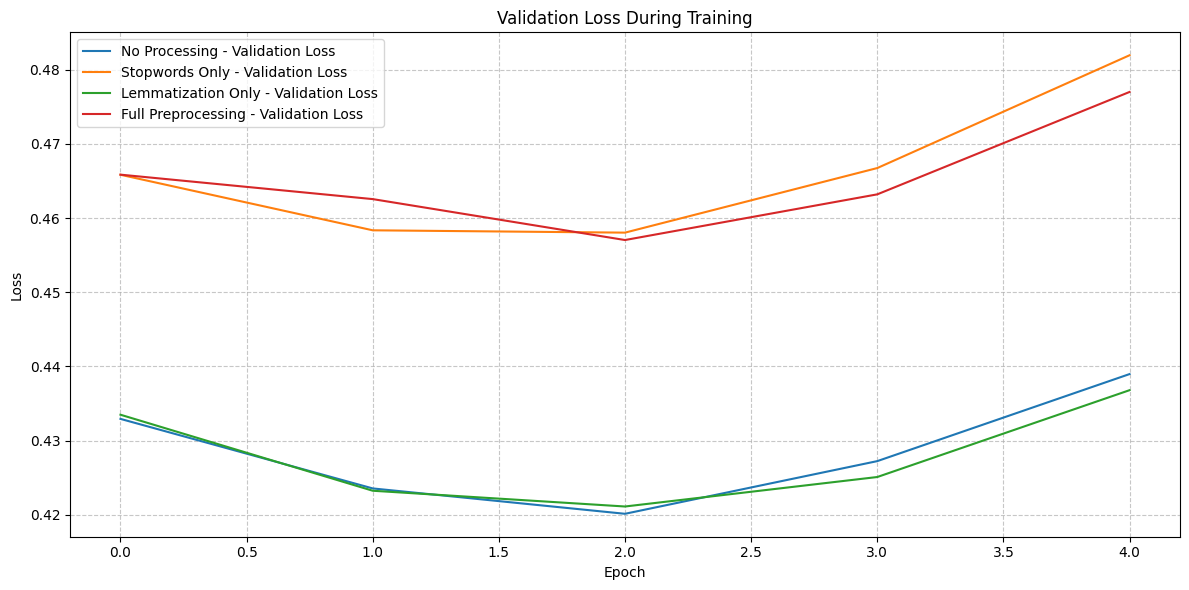

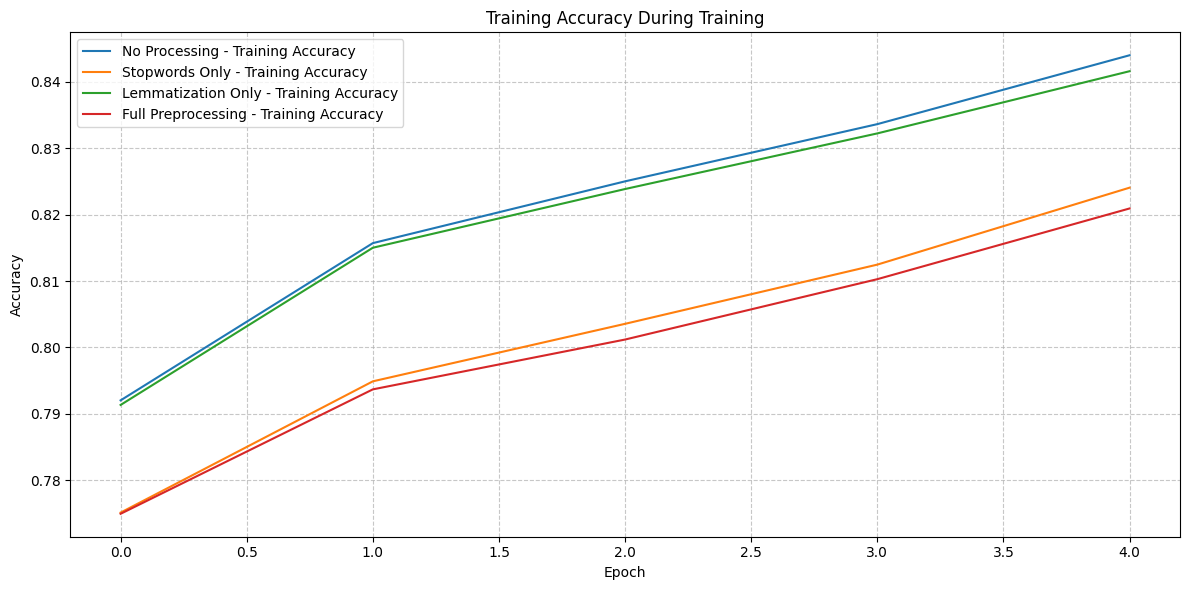

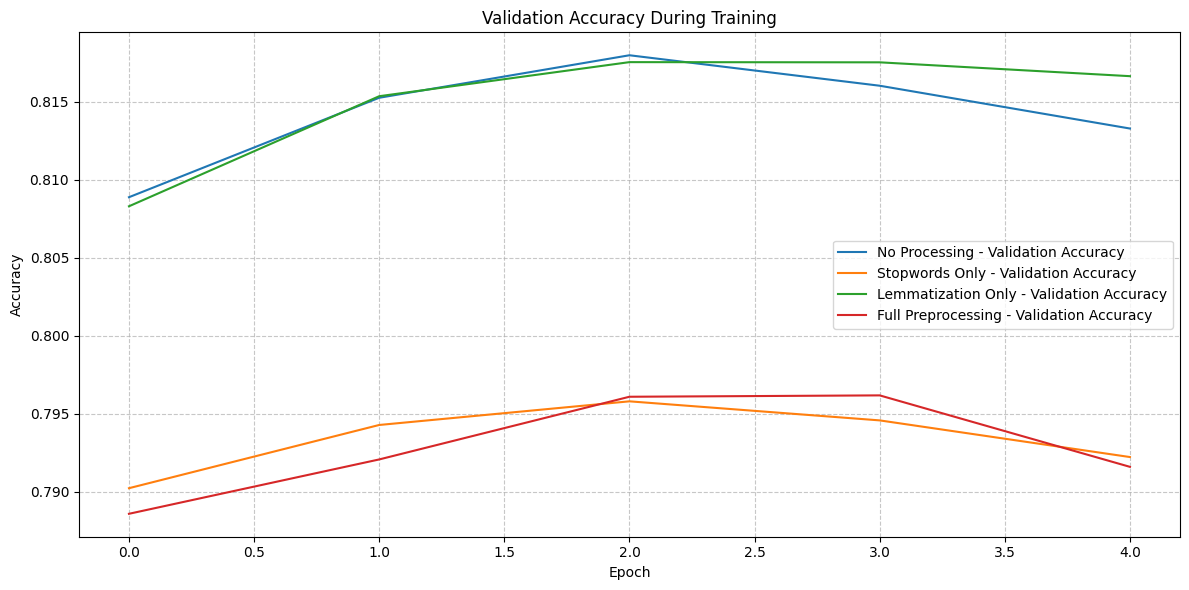


Detailed Results:
--------------------------------------------------
No Processing       : Test Accuracy: 0.8180
Stopwords Only      : Test Accuracy: 0.7958
Lemmatization Only  : Test Accuracy: 0.8175
Full Preprocessing  : Test Accuracy: 0.7961


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, InputLayer
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from multiprocessing import Pool
from functools import partial
import swifter
from tqdm import tqdm

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

class PreprocessingComparison:
    def __init__(self, max_vocab=50000, max_length=20, embedding_dim=100):
        self.max_vocab = max_vocab
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.lemmatizer = WordNetLemmatizer()
        # Pre-compile regex patterns
        self.url_pattern = re.compile(r'https?://\S+|www\.\S+')
        self.html_pattern = re.compile(r'<.*?>')
        self.punctuation_pattern = re.compile(r'[^\w\s]')

        # Convert stopwords to set for O(1) lookup and cache it
        self.stop_words = set(stopwords.words('english'))

        # Pre-cache common lemmatizations
        self.lemma_cache = {}

        # Initialize GPU settings
        self._setup_gpu()

    def _setup_gpu(self):
        """Configure GPU settings for optimal performance"""
        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            for device in physical_devices:
                try:
                    tf.config.experimental.set_memory_growth(device, True)
                    print(f"Memory growth enabled for {device}")
                except RuntimeError as e:
                    print(f"Error setting memory growth: {e}")

    def load_data(self, data_path):
        """Load and prepare the Sentiment140 dataset"""
        try:
            # Use chunked reading for better memory management
            chunks = pd.read_csv(data_path,
                               names=['target', 'id', 'date', 'flag', 'user', 'text'],
                               encoding="ISO-8859-1",
                               chunksize=100000)

            df = pd.concat(chunks)
            X = np.array(df['text'])
            Y = np.array(df['target'])
            Y[Y == 4] = 1  # Convert target 4 to 1 for positive sentiment
            return X, Y
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

    def _clean_text(self, text):
        """Basic text cleaning with cached regex patterns"""
        text = str(text).lower()
        text = self.url_pattern.sub('', text)
        text = self.html_pattern.sub('', text)
        text = self.punctuation_pattern.sub('', text)
        return text

    def _process_text_batch(self, texts, method):
        """Process a batch of texts using specified method"""
        processed_texts = []
        for text in texts:
            text = self._clean_text(text)
            tokens = word_tokenize(text)

            if method in ['stopwords_only', 'full']:
                tokens = [token for token in tokens if token not in self.stop_words]

            if method in ['lemmatization_only', 'full']:
                tokens = [self.lemma_cache.get(token) or
                         self.lemma_cache.setdefault(token, self.lemmatizer.lemmatize(token))
                         for token in tokens]

            processed_texts.append(' '.join(tokens))
        return processed_texts

    def _parallel_process(self, texts, method):
        """Process texts in parallel"""
        # Split texts into chunks for parallel processing
        n_cores = Pool()._processes
        chunk_size = max(1, len(texts) // (n_cores * 4))
        chunks = [texts[i:i + chunk_size] for i in range(0, len(texts), chunk_size)]

        with Pool() as pool:
            processed_chunks = list(tqdm(
                pool.imap(partial(self._process_text_batch, method=method), chunks),
                total=len(chunks),
                desc=f"Processing with {method}"
            ))

        return [text for chunk in processed_chunks for text in chunk]

    def preprocess_no_processing(self, texts):
        """No preprocessing, just lowercase"""
        return self._parallel_process(texts, 'no_processing')

    def preprocess_stopwords_only(self, texts):
        """Remove stopwords only"""
        return self._parallel_process(texts, 'stopwords_only')

    def preprocess_lemmatization_only(self, texts):
        """Apply lemmatization only"""
        return self._parallel_process(texts, 'lemmatization_only')

    def preprocess_full(self, texts):
        """Apply both stopword removal and lemmatization"""
        return self._parallel_process(texts, 'full')

    def prepare_sequences(self, texts, tokenizer=None):
        """Convert text to padded sequences"""
        if tokenizer is None:
            tokenizer = Tokenizer(num_words=self.max_vocab, filters='@')
            tokenizer.fit_on_texts(texts)

        # Process sequences in batches
        batch_size = 10000
        sequences = []
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            sequences.extend(tokenizer.texts_to_sequences(batch))

        padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
            sequences,
            maxlen=self.max_length,
            padding='pre',
            truncating='pre'
        )
        return padded_sequences, tokenizer

    def build_model(self):
        """Build model with mixed precision and optimized configuration"""
        # Enable mixed precision for better GPU utilization
        tf.keras.mixed_precision.set_global_policy('mixed_float16')

        model = Sequential([
            InputLayer(input_shape=(self.max_length,)),
            Embedding(self.max_vocab, self.embedding_dim,
                     input_length=self.max_length,
                     embeddings_regularizer=tf.keras.regularizers.l2(1e-5)),
            Bidirectional(LSTM(64, return_sequences=False,
                             unroll=True,
                             kernel_regularizer=tf.keras.regularizers.l2(1e-5))),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        optimizer = tf.keras.optimizers.Adam(
            learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=0.001,
                decay_steps=1000,
                decay_rate=0.9
            )
        )

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

    def train_and_evaluate(self, X_train, X_test, y_train, y_test, preprocessing_name):
        """Train model and evaluate performance"""
        # Convert labels to float32 for GPU compatibility
        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')

        # Create training and validation datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
            .shuffle(10000)\
            .batch(1024)

        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
            .batch(1024)

        model = self.build_model()

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        history = model.fit(
            train_dataset,
            epochs=5,
            validation_data=test_dataset,
            callbacks=[early_stopping],
            verbose=1
        )

        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

        # Calculate F1 score
        y_pred_prob = model.predict(test_dataset)
        y_pred = (y_pred_prob > 0.5).astype("int32")

        f1 = f1_score(y_test, y_pred)

        return history.history, test_loss, test_accuracy, f1

    def compare_preprocessing_methods(self, X, y):
        """Compare different preprocessing methods"""
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        results = {}
        preprocessing_methods = {
            'No Processing': self.preprocess_no_processing,
            'Stopwords Only': self.preprocess_stopwords_only,
            'Lemmatization Only': self.preprocess_lemmatization_only,
            'Full Preprocessing': self.preprocess_full
        }

        for name, method in preprocessing_methods.items():
            print(f"\nTraining model with {name}")

            X_train_processed = method(X_train_raw)
            X_test_processed = method(X_test_raw)

            X_train_seq, tokenizer = self.prepare_sequences(X_train_processed)
            X_test_seq, _ = self.prepare_sequences(X_test_processed, tokenizer)

            history, test_loss, test_accuracy, f1_score_val = self.train_and_evaluate(
                X_train_seq, X_test_seq, y_train, y_test, name
            )

            results[name] = {
                'Test Loss': test_loss,
                'Test Accuracy': test_accuracy,
                'F1 Score': f1_score_val,
                'History': history
            }

        return results

    def plot_results(self, results):
        """Plot comparison results"""
        methods = list(results.keys())

        # Figure 1: Test Accuracy
        plt.figure(figsize=(12, 6))
        accuracies = [results[method]['Test Accuracy'] for method in methods]
        bars = plt.bar(methods, accuracies, color='skyblue')
        plt.title('Test Accuracy by Preprocessing Method')
        plt.xticks(rotation=45)
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                    f'{accuracy:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Figure 2: F1 Scores
        plt.figure(figsize=(12, 6))
        f1_scores = [results[method]['F1 Score'] for method in methods]
        bars = plt.bar(methods, f1_scores, color='lightcoral')
        plt.title('F1 Score by Preprocessing Method')
        plt.xticks(rotation=45)
        plt.ylabel('F1 Score')
        plt.grid(True, linestyle='--', alpha=0.7)
        for bar, f1_score in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                    f'{f1_score:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Figure 3: Training Loss
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['loss'], label=f'{method} - Training Loss')
        plt.title('Training Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 4: Validation Loss
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['val_loss'],
                    label=f'{method} - Validation Loss')
        plt.title('Validation Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 5: Training Accuracy
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['accuracy'],
                    label=f'{method} - Training Accuracy')
        plt.title('Training Accuracy During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 6: Validation Accuracy
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['val_accuracy'],
                    label=f'{method} - Validation Accuracy')
        plt.title('Validation Accuracy During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\nDetailed Results:")
        print("-" * 50)
        for method, metrics in results.items():
            print(f"{method:20s}: Test Accuracy: {metrics['Test Accuracy']:.4f}")

if __name__ == "__main__":
    comparison = PreprocessingComparison()
    X, y = comparison.load_data("training.1600000.processed.noemoticon.csv")
    results = comparison.compare_preprocessing_methods(X, y)
    comparison.plot_results(results)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



Training model with No Processing


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7614 - loss: 0.4850 - val_accuracy: 0.8098 - val_loss: 0.4126
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8197 - loss: 0.3966 - val_accuracy: 0.8154 - val_loss: 0.4046
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8358 - loss: 0.3663 - val_accuracy: 0.8130 - val_loss: 0.4201
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8521 - loss: 0.3348 - val_accuracy: 0.8084 - val_loss: 0.4532
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8693 - loss: 0.3001 - val_accuracy: 0.8043 - val_loss: 0.5124
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step

Training model with Stopwords Only
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.7586 - loss: 0.4936 - val_accuracy: 0.7994 - val_loss: 0.4291
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - accuracy: 0.8074 - loss: 0.4168 - val_accuracy: 0.8030 - val_loss: 0.4253
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8216 - loss: 0.3912 - val_accuracy: 0.8016 - val_loss: 0.4377
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8371 - loss: 0.3622 - val_accuracy: 0.7967 - val_loss: 0.4727
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8535 - loss: 0.3299 - val_accuracy: 0.7907 - val_loss: 0.5436
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step

Training model with Lemmatization Only
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.7694 - loss: 0.4768 - val_accuracy: 0.8160 - val_loss: 0.4011
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8244 - loss: 0.3891 - val_accuracy: 0.8225 - val_loss: 0.3932
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8382 - loss: 0.3632 - val_accuracy: 0.8211 - val_loss: 0.3987
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8508 - loss: 0.3383 - val_accuracy: 0.8176 - val_loss: 0.4260
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8637 - loss: 0.3113 - val_accuracy: 0.8139 - val_loss: 0.4673
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step

Training model with Full Preprocessing
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7584 - loss: 0.4945 - val_accuracy: 0.7976 - val_loss: 0.4319
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8064 - loss: 0.4192 - val_accuracy: 0.8032 - val_loss: 0.4246
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8195 - loss: 0.3945 - val_accuracy: 0.8019 - val_loss: 0.4329
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8346 - loss: 0.3673 - val_accuracy: 0.7983 - val_loss: 0.4681
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.8506 - loss: 0.3352 - val_accuracy: 0.7922 - val_loss: 0.5182
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


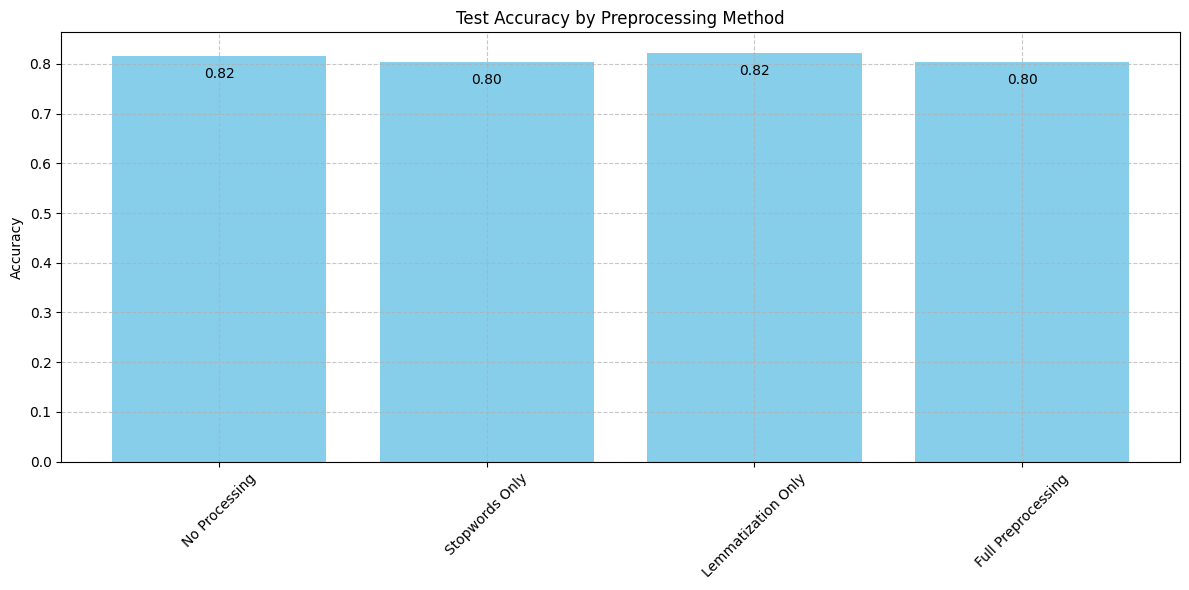

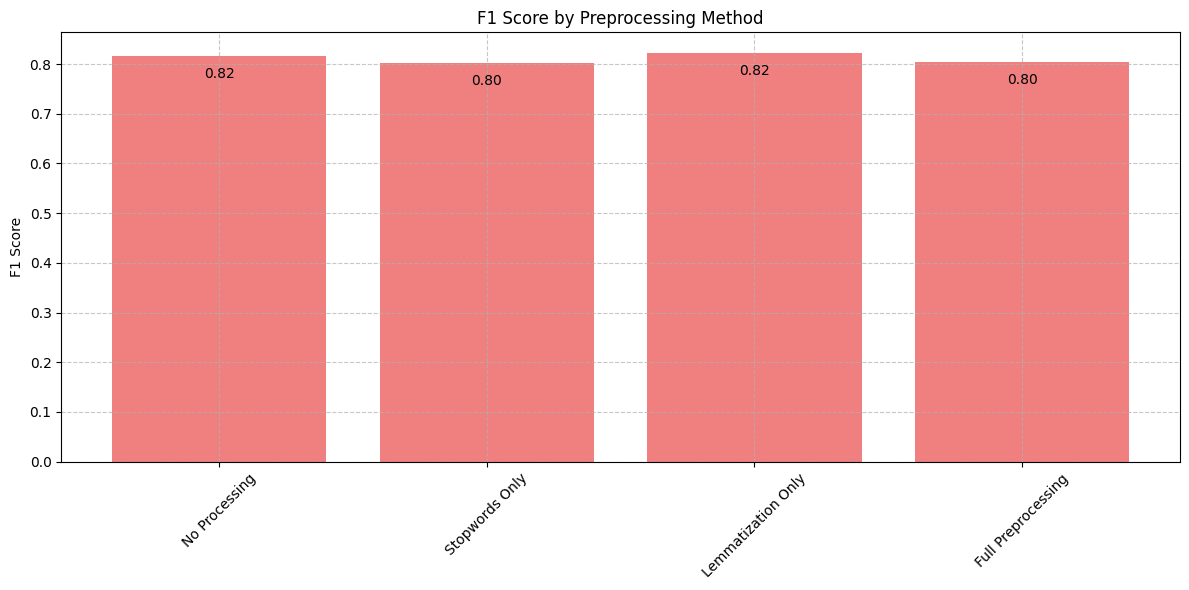

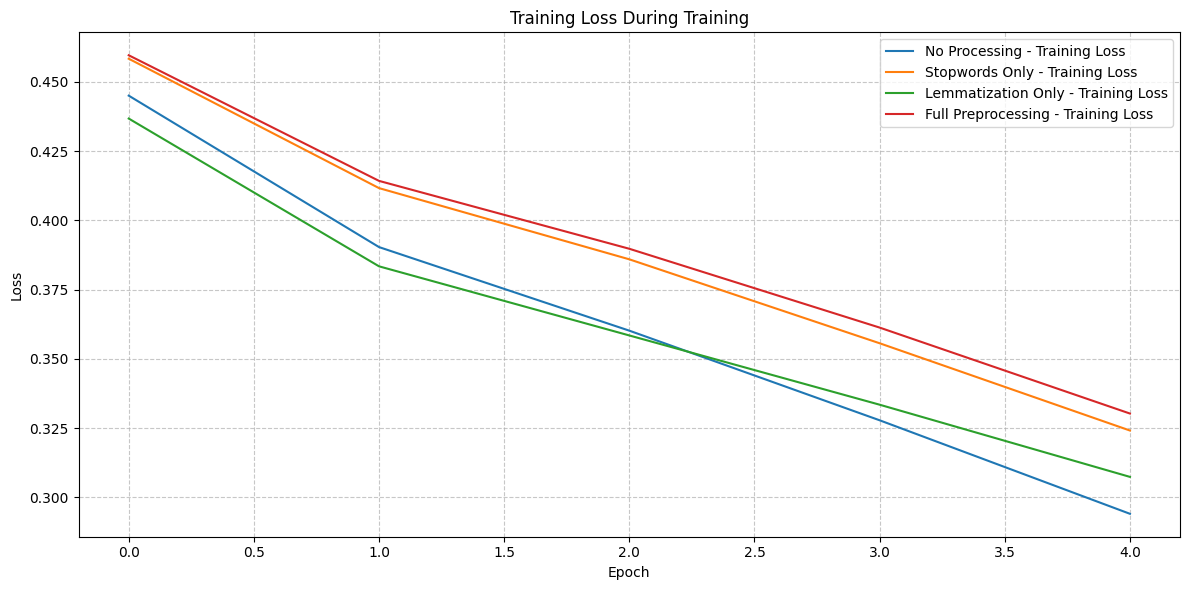

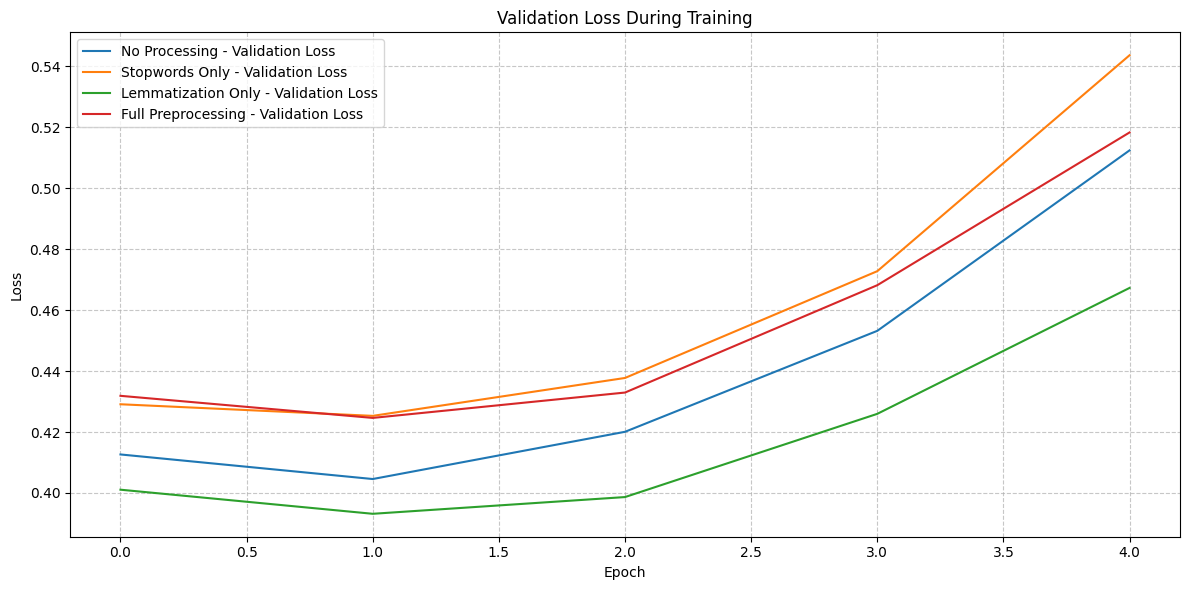

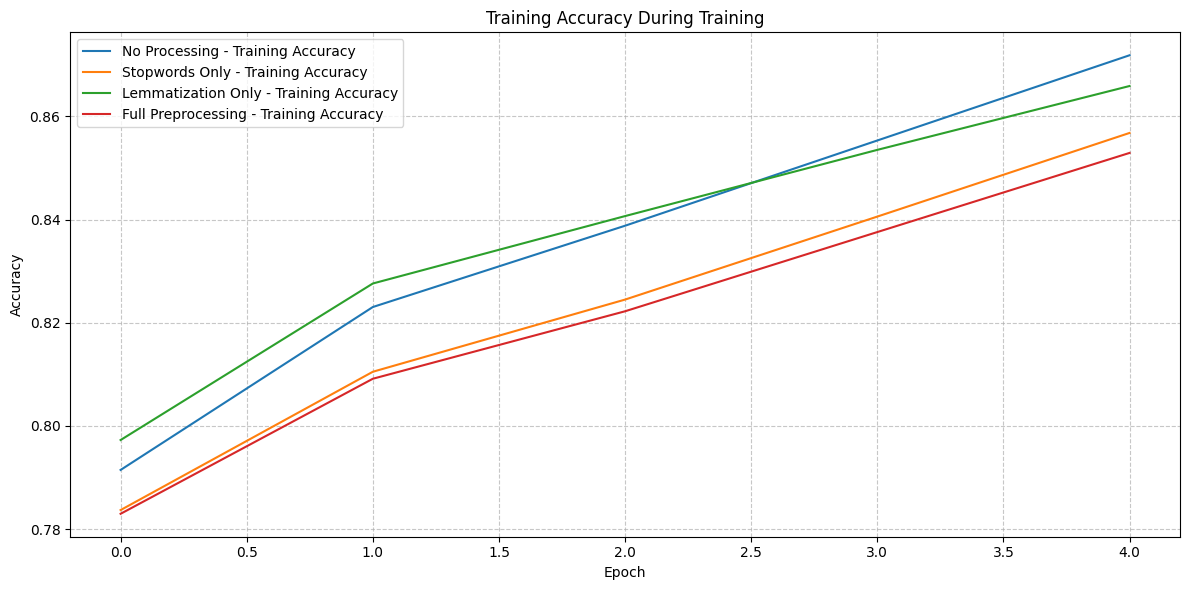

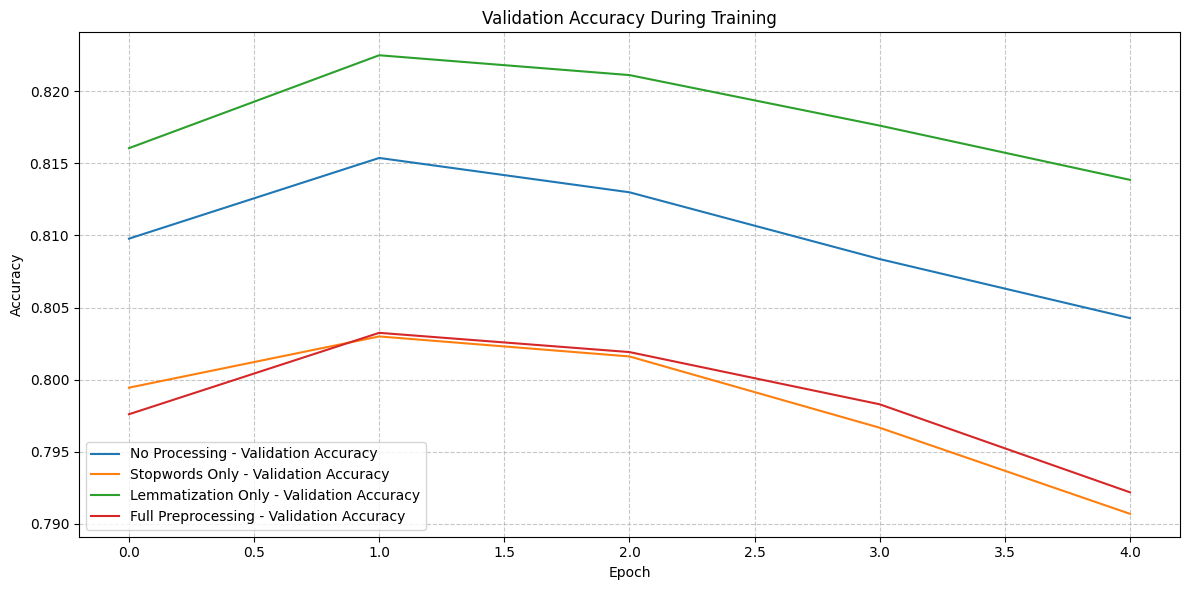


Detailed Results:
--------------------------------------------------
No Processing       : Test Accuracy: 0.8154
Stopwords Only      : Test Accuracy: 0.8030
Lemmatization Only  : Test Accuracy: 0.8225
Full Preprocessing  : Test Accuracy: 0.8032


In [ ]:
#lstm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
# Import Tokenizer from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, InputLayer
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
class PreprocessingComparison:
    def __init__(self, max_vocab=50000, max_length=20, embedding_dim=100):
        self.max_vocab = max_vocab
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # Set memory growth for GPU
        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, True)

    def load_data(self, data_path):
        """Load and prepare the Sentiment140 dataset"""
        df = pd.read_csv(data_path,
                        names=['target', 'id', 'date', 'flag', 'user', 'text'],
                        encoding="ISO-8859-1")
        X = np.array(df['text'])
        Y = np.array(df['target'])
        Y[Y == 4] = 1  # Convert target 4 to 1 for positive sentiment
        return X, Y

    def preprocess_no_processing(self, texts):
        """No preprocessing, just lowercase"""
        return [text.lower() for text in texts]

    def preprocess_stopwords_only(self, texts):
        """Remove stopwords only"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [token for token in tokens if token not in self.stop_words]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def preprocess_lemmatization_only(self, texts):
        """Apply lemmatization only"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def preprocess_full(self, texts):
        """Apply both stopword removal and lemmatization"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [self.lemmatizer.lemmatize(token)
                     for token in tokens if token not in self.stop_words]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def prepare_sequences(self, texts, tokenizer=None):
        """Convert text to padded sequences"""
        if tokenizer is None:
            tokenizer = Tokenizer(num_words=self.max_vocab, filters='@')
            tokenizer.fit_on_texts(texts)

        sequences = tokenizer.texts_to_sequences(texts)
        padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
            sequences,
            maxlen=self.max_length,
            padding='pre',
            truncating='pre'
        )
        return padded_sequences, tokenizer

    def build_model(self):
        """Build LSTM model with GPU compatibility"""
        model = Sequential([
            InputLayer(input_shape=(self.max_length,)),
            Embedding(self.max_vocab, self.embedding_dim, input_length=self.max_length),
            LSTM(64, return_sequences=False, unroll=True),  # Standard LSTM layer
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        # Use mixed precision for better GPU performance
        tf.keras.mixed_precision.set_global_policy('mixed_float16')

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model


    def train_and_evaluate(self, X_train, X_test, y_train, y_test, preprocessing_name):
        """Train model and evaluate performance"""
        # Convert labels to float32 for GPU compatibility
        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')

        # Create training and validation datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
            .shuffle(10000)\
            .batch(1024)

        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
            .batch(1024)

        model = self.build_model()

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        history = model.fit(
            train_dataset,
            epochs=5,
            validation_data=test_dataset,
            callbacks=[early_stopping],
            verbose=1
        )

        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

        # Calculate F1 score
        y_pred_prob = model.predict(test_dataset)
        y_pred = (y_pred_prob > 0.5).astype("int32")

        f1 = f1_score(y_test, y_pred)

        return history.history, test_loss, test_accuracy, f1


    def compare_preprocessing_methods(self, X, y):
        """Compare different preprocessing methods"""
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        results = {}

        preprocessing_methods = {
            'No Processing': self.preprocess_no_processing,
            'Stopwords Only': self.preprocess_stopwords_only,
            'Lemmatization Only': self.preprocess_lemmatization_only,
            'Full Preprocessing': self.preprocess_full
        }

        histories = {}
        for name, method in preprocessing_methods.items():
            print(f"\nTraining model with {name}")

            X_train_processed = method(X_train_raw)
            X_test_processed = method(X_test_raw)

            X_train_seq, tokenizer = self.prepare_sequences(X_train_processed)
            X_test_seq, _ = self.prepare_sequences(X_test_processed, tokenizer)

            history, test_loss, test_accuracy, f1_score_val = self.train_and_evaluate(
                X_train_seq, X_test_seq, y_train, y_test, name
            )

            results[name] = {
                'Test Loss': test_loss,
                'Test Accuracy': test_accuracy,
                'F1 Score': f1_score_val,
                'History': history
            }

        return results



    def plot_results(self, results):
        """Plot comparison results"""
        methods = list(results.keys())

        # Figure 1: Test Accuracy
        plt.figure(figsize=(12, 6))
        accuracies = [results[method]['Test Accuracy'] for method in methods]
        bars = plt.bar(methods, accuracies, color='skyblue')
        plt.title('Test Accuracy by Preprocessing Method')
        plt.xticks(rotation=45)
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                    f'{accuracy:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Figure 2: F1 Scores
        plt.figure(figsize=(12, 6))
        f1_scores = [results[method]['F1 Score'] for method in methods]
        bars = plt.bar(methods, f1_scores, color='lightcoral')
        plt.title('F1 Score by Preprocessing Method')
        plt.xticks(rotation=45)
        plt.ylabel('F1 Score')
        plt.grid(True, linestyle='--', alpha=0.7)
        for bar, f1_score in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                    f'{f1_score:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Figure 3: Training Loss
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['loss'], label=f'{method} - Training Loss')
        plt.title('Training Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 4: Validation Loss
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['val_loss'],
                    label=f'{method} - Validation Loss')
        plt.title('Validation Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 5: Training Accuracy
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['accuracy'],
                    label=f'{method} - Training Accuracy')
        plt.title('Training Accuracy During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 6: Validation Accuracy
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['val_accuracy'],
                    label=f'{method} - Validation Accuracy')
        plt.title('Validation Accuracy During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\nDetailed Results:")
        print("-" * 50)
        for method, metrics in results.items():
            print(f"{method:20s}: Test Accuracy: {metrics['Test Accuracy']:.4f}")


if __name__ == "__main__":
    comparison = PreprocessingComparison()
    X, y = comparison.load_data("training.1600000.processed.noemoticon.csv")
    results = comparison.compare_preprocessing_methods(X, y)
    comparison.plot_results(results)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...



Training model with No Processing


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7628 - loss: 0.4846 - val_accuracy: 0.8100 - val_loss: 0.4125
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8197 - loss: 0.3963 - val_accuracy: 0.8138 - val_loss: 0.4053
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8364 - loss: 0.3665 - val_accuracy: 0.8124 - val_loss: 0.4108
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8532 - loss: 0.3354 - val_accuracy: 0.8061 - val_loss: 0.4423
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8705 - loss: 0.3013 - val_accuracy: 0.8023 - val_loss: 0.4968
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step

Training model with Stopwords Only
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.7591 - loss: 0.4913 - val_accuracy: 0.7999 - val_loss: 0.4290
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8088 - loss: 0.4155 - val_accuracy: 0.8034 - val_loss: 0.4234
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8229 - loss: 0.3897 - val_accuracy: 0.8018 - val_loss: 0.4318
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8389 - loss: 0.3609 - val_accuracy: 0.7942 - val_loss: 0.4556
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8555 - loss: 0.3295 - val_accuracy: 0.7894 - val_loss: 0.5020
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

Training model with Lemmatization Only
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.7678 - loss: 0.4783 - val_accuracy: 0.8141 - val_loss: 0.4050
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8232 - loss: 0.3910 - val_accuracy: 0.8215 - val_loss: 0.3927
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.8381 - loss: 0.3629 - val_accuracy: 0.8216 - val_loss: 0.3947
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8507 - loss: 0.3395 - val_accuracy: 0.8189 - val_loss: 0.4082
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8634 - loss: 0.3149 - val_accuracy: 0.8155 - val_loss: 0.4480
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step

Training model with Full Preprocessing
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.7567 - loss: 0.4950 - val_accuracy: 0.7981 - val_loss: 0.4325
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8068 - loss: 0.4184 - val_accuracy: 0.8025 - val_loss: 0.4246
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8215 - loss: 0.3923 - val_accuracy: 0.7999 - val_loss: 0.4319
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8368 - loss: 0.3651 - val_accuracy: 0.7942 - val_loss: 0.4571
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8527 - loss: 0.3348 - val_accuracy: 0.7884 - val_loss: 0.5005
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step


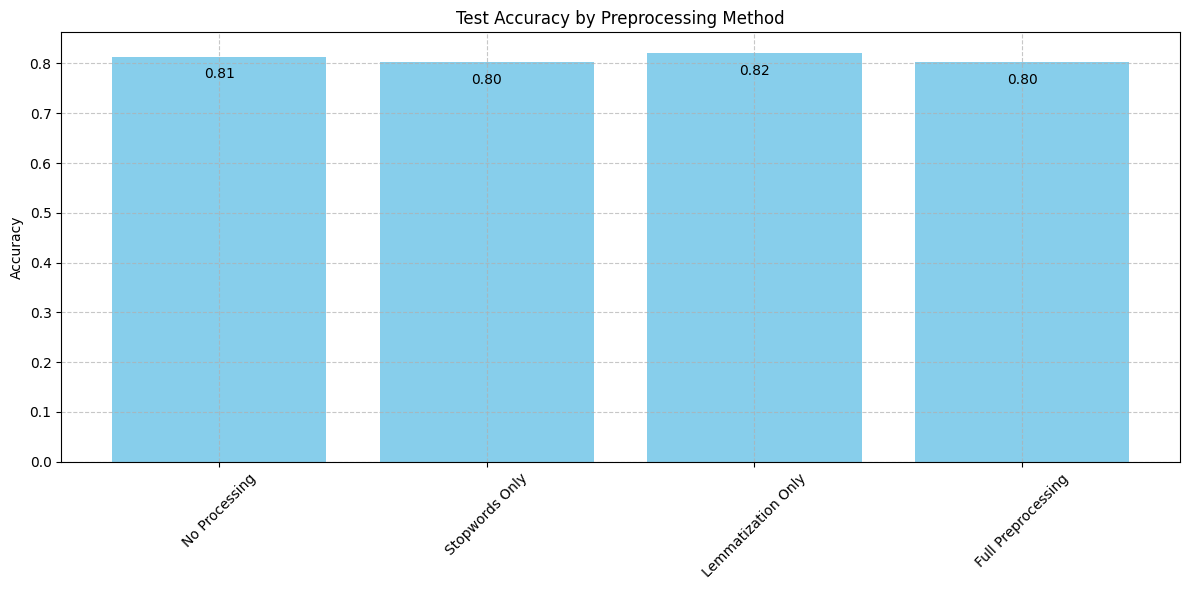

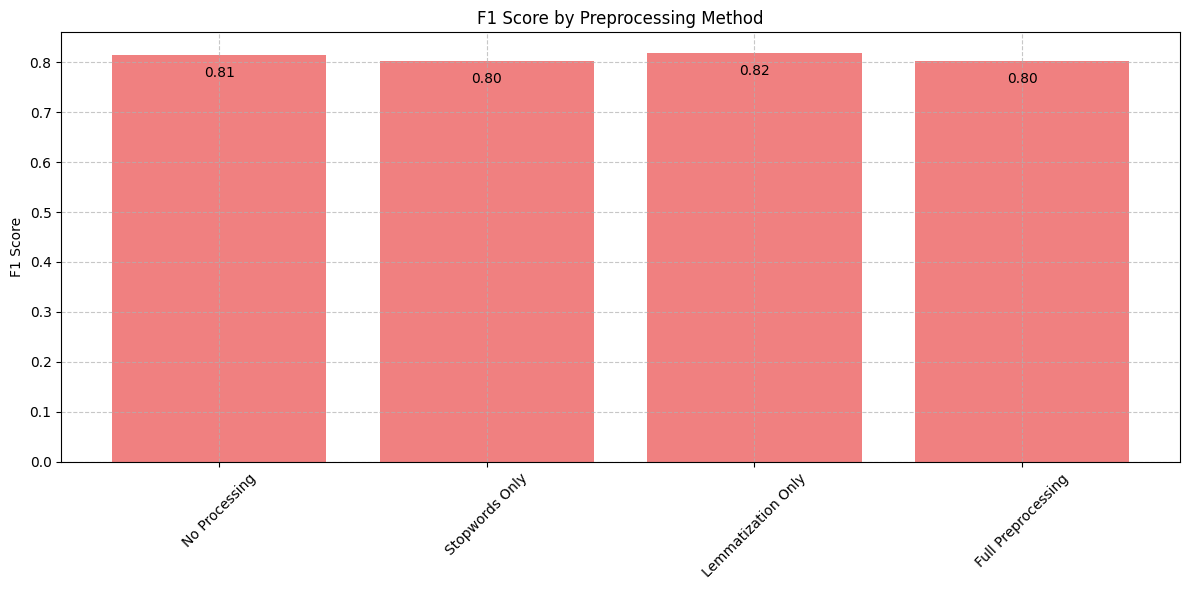

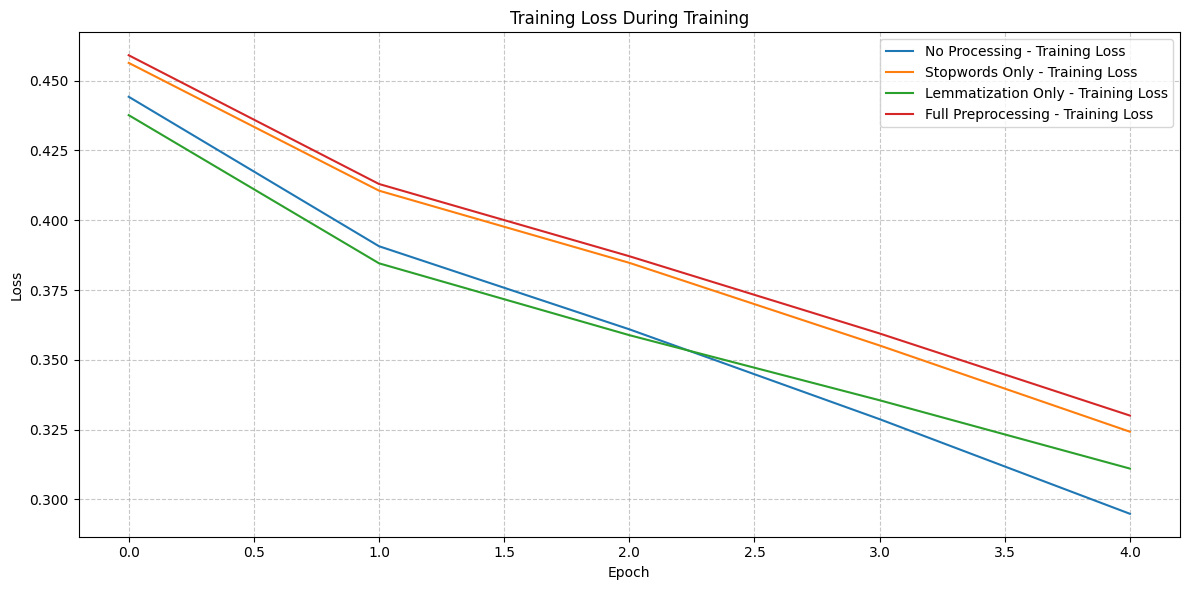

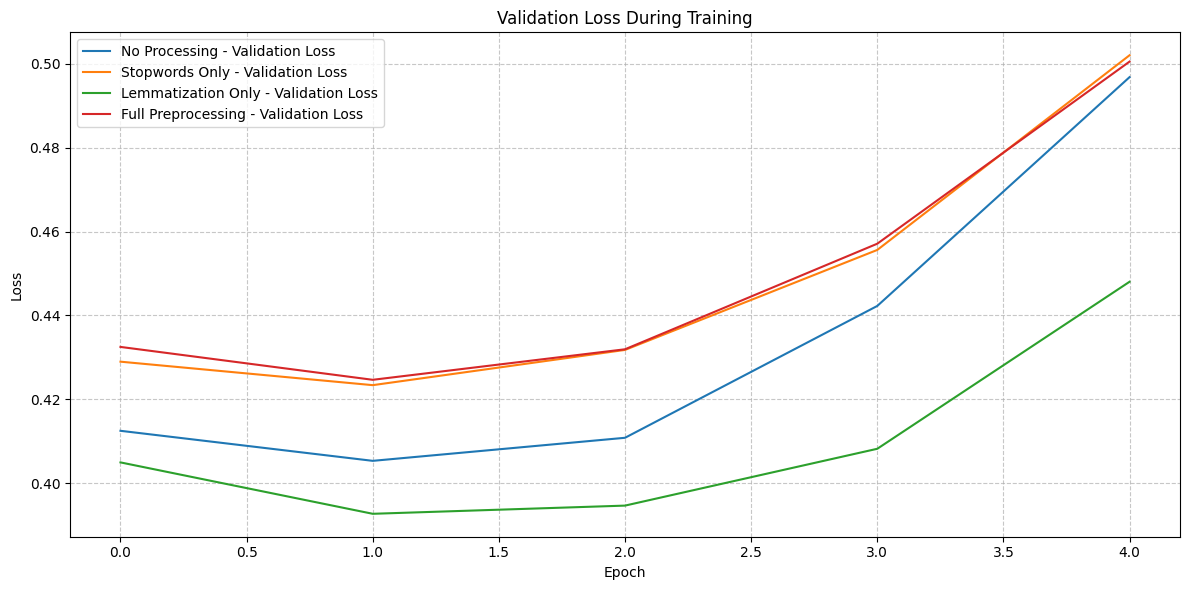

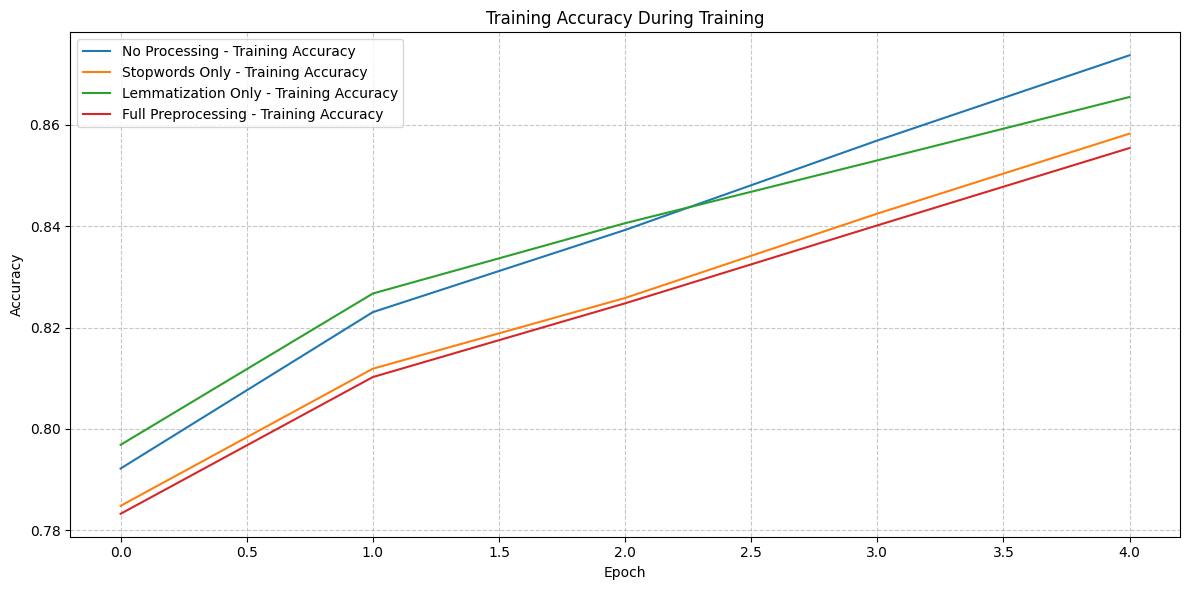

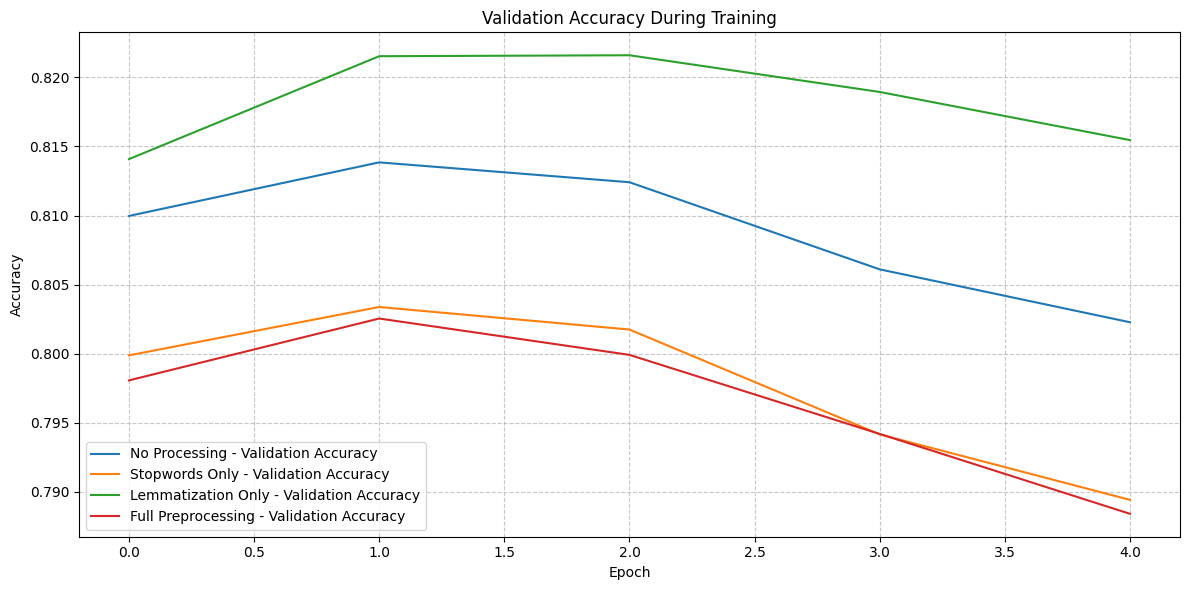


Detailed Results:
--------------------------------------------------
No Processing       : Test Accuracy: 0.8138
Stopwords Only      : Test Accuracy: 0.8034
Lemmatization Only  : Test Accuracy: 0.8215
Full Preprocessing  : Test Accuracy: 0.8025


In [ ]:
# final gru
#lstm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
# Import Tokenizer from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, InputLayer, GRU
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
class PreprocessingComparison:
    def __init__(self, max_vocab=50000, max_length=20, embedding_dim=100):
        self.max_vocab = max_vocab
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # Set memory growth for GPU
        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, True)

    def load_data(self, data_path):
        """Load and prepare the Sentiment140 dataset"""
        df = pd.read_csv(data_path,
                        names=['target', 'id', 'date', 'flag', 'user', 'text'],
                        encoding="ISO-8859-1")
        X = np.array(df['text'])
        Y = np.array(df['target'])
        Y[Y == 4] = 1  # Convert target 4 to 1 for positive sentiment
        return X, Y

    def preprocess_no_processing(self, texts):
        """No preprocessing, just lowercase"""
        return [text.lower() for text in texts]

    def preprocess_stopwords_only(self, texts):
        """Remove stopwords only"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [token for token in tokens if token not in self.stop_words]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def preprocess_lemmatization_only(self, texts):
        """Apply lemmatization only"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def preprocess_full(self, texts):
        """Apply both stopword removal and lemmatization"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [self.lemmatizer.lemmatize(token)
                     for token in tokens if token not in self.stop_words]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def prepare_sequences(self, texts, tokenizer=None):
        """Convert text to padded sequences"""
        if tokenizer is None:
            tokenizer = Tokenizer(num_words=self.max_vocab, filters='@')
            tokenizer.fit_on_texts(texts)

        sequences = tokenizer.texts_to_sequences(texts)
        padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
            sequences,
            maxlen=self.max_length,
            padding='pre',
            truncating='pre'
        )
        return padded_sequences, tokenizer

    def build_model(self):
        """Build GRU model with GPU compatibility"""
        model = Sequential([
            InputLayer(input_shape=(self.max_length,)),
            Embedding(self.max_vocab, self.embedding_dim, input_length=self.max_length),
            GRU(64, return_sequences=False, unroll=True),  # GRU layer
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        # Use mixed precision for better GPU performance
        tf.keras.mixed_precision.set_global_policy('mixed_float16')

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model



    def train_and_evaluate(self, X_train, X_test, y_train, y_test, preprocessing_name):
        """Train model and evaluate performance"""
        # Convert labels to float32 for GPU compatibility
        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')

        # Create training and validation datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
            .shuffle(10000)\
            .batch(1024)

        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
            .batch(1024)

        model = self.build_model()

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        history = model.fit(
            train_dataset,
            epochs=5,
            validation_data=test_dataset,
            callbacks=[early_stopping],
            verbose=1
        )

        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

        # Calculate F1 score
        y_pred_prob = model.predict(test_dataset)
        y_pred = (y_pred_prob > 0.5).astype("int32")

        f1 = f1_score(y_test, y_pred)

        return history.history, test_loss, test_accuracy, f1


    def compare_preprocessing_methods(self, X, y):
        """Compare different preprocessing methods"""
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        results = {}

        preprocessing_methods = {
            'No Processing': self.preprocess_no_processing,
            'Stopwords Only': self.preprocess_stopwords_only,
            'Lemmatization Only': self.preprocess_lemmatization_only,
            'Full Preprocessing': self.preprocess_full
        }

        histories = {}
        for name, method in preprocessing_methods.items():
            print(f"\nTraining model with {name}")

            X_train_processed = method(X_train_raw)
            X_test_processed = method(X_test_raw)

            X_train_seq, tokenizer = self.prepare_sequences(X_train_processed)
            X_test_seq, _ = self.prepare_sequences(X_test_processed, tokenizer)

            history, test_loss, test_accuracy, f1_score_val = self.train_and_evaluate(
                X_train_seq, X_test_seq, y_train, y_test, name
            )

            results[name] = {
                'Test Loss': test_loss,
                'Test Accuracy': test_accuracy,
                'F1 Score': f1_score_val,
                'History': history
            }

        return results



    def plot_results(self, results):
        """Plot comparison results"""
        methods = list(results.keys())

        # Figure 1: Test Accuracy
        plt.figure(figsize=(12, 6))
        accuracies = [results[method]['Test Accuracy'] for method in methods]
        bars = plt.bar(methods, accuracies, color='skyblue')
        plt.title('Test Accuracy by Preprocessing Method')
        plt.xticks(rotation=45)
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                    f'{accuracy:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Figure 2: F1 Scores
        plt.figure(figsize=(12, 6))
        f1_scores = [results[method]['F1 Score'] for method in methods]
        bars = plt.bar(methods, f1_scores, color='lightcoral')
        plt.title('F1 Score by Preprocessing Method')
        plt.xticks(rotation=45)
        plt.ylabel('F1 Score')
        plt.grid(True, linestyle='--', alpha=0.7)
        for bar, f1_score in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                    f'{f1_score:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Figure 3: Training Loss
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['loss'], label=f'{method} - Training Loss')
        plt.title('Training Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 4: Validation Loss
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['val_loss'],
                    label=f'{method} - Validation Loss')
        plt.title('Validation Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 5: Training Accuracy
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['accuracy'],
                    label=f'{method} - Training Accuracy')
        plt.title('Training Accuracy During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 6: Validation Accuracy
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['val_accuracy'],
                    label=f'{method} - Validation Accuracy')
        plt.title('Validation Accuracy During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\nDetailed Results:")
        print("-" * 50)
        for method, metrics in results.items():
            print(f"{method:20s}: Test Accuracy: {metrics['Test Accuracy']:.4f}")


if __name__ == "__main__":
    comparison = PreprocessingComparison()
    X, y = comparison.load_data("training.1600000.processed.noemoticon.csv")
    results = comparison.compare_preprocessing_methods(X, y)
    comparison.plot_results(results)


In [ ]:
#final bilstm
#lstm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
# Import Tokenizer from tensorflow.keras.preprocessing.text
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, InputLayer
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
class PreprocessingComparison:
    def __init__(self, max_vocab=50000, max_length=20, embedding_dim=100):
        self.max_vocab = max_vocab
        self.max_length = max_length
        self.embedding_dim = embedding_dim
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

        # Set memory growth for GPU
        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, True)

    def load_data(self, data_path):
        """Load and prepare the Sentiment140 dataset"""
        df = pd.read_csv(data_path,
                        names=['target', 'id', 'date', 'flag', 'user', 'text'],
                        encoding="ISO-8859-1")
        X = np.array(df['text'])
        Y = np.array(df['target'])
        Y[Y == 4] = 1  # Convert target 4 to 1 for positive sentiment
        return X, Y

    def preprocess_no_processing(self, texts):
        """No preprocessing, just lowercase"""
        return [text.lower() for text in texts]

    def preprocess_stopwords_only(self, texts):
        """Remove stopwords only"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [token for token in tokens if token not in self.stop_words]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def preprocess_lemmatization_only(self, texts):
        """Apply lemmatization only"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def preprocess_full(self, texts):
        """Apply both stopword removal and lemmatization"""
        processed_texts = []
        for text in texts:
            tokens = word_tokenize(text.lower())
            tokens = [self.lemmatizer.lemmatize(token)
                     for token in tokens if token not in self.stop_words]
            processed_texts.append(' '.join(tokens))
        return processed_texts

    def prepare_sequences(self, texts, tokenizer=None):
        """Convert text to padded sequences"""
        if tokenizer is None:
            tokenizer = Tokenizer(num_words=self.max_vocab, filters='@')
            tokenizer.fit_on_texts(texts)

        sequences = tokenizer.texts_to_sequences(texts)
        padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
            sequences,
            maxlen=self.max_length,
            padding='pre',
            truncating='pre'
        )
        return padded_sequences, tokenizer

    def build_model(self):
        """Build bilstm LSTM model with GPU compatibility"""
        model = Sequential([
            InputLayer(input_shape=(self.max_length,)),
            Embedding(self.max_vocab, self.embedding_dim, input_length=self.max_length),
            Bidirectional(LSTM(64, return_sequences=False, unroll=True)),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        # Use mixed precision for better GPU performance
        tf.keras.mixed_precision.set_global_policy('mixed_float16')

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model


    def train_and_evaluate(self, X_train, X_test, y_train, y_test, preprocessing_name):
        """Train model and evaluate performance"""
        # Convert labels to float32 for GPU compatibility
        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')

        # Create training and validation datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
            .shuffle(10000)\
            .batch(1024)

        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))\
            .batch(1024)

        model = self.build_model()

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )

        history = model.fit(
            train_dataset,
            epochs=5,
            validation_data=test_dataset,
            callbacks=[early_stopping],
            verbose=1
        )

        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

        # Calculate F1 score
        y_pred_prob = model.predict(test_dataset)
        y_pred = (y_pred_prob > 0.5).astype("int32")

        f1 = f1_score(y_test, y_pred)

        return history.history, test_loss, test_accuracy, f1


    def compare_preprocessing_methods(self, X, y):
        """Compare different preprocessing methods"""
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        results = {}

        preprocessing_methods = {
            'No Processing': self.preprocess_no_processing,
            'Stopwords Only': self.preprocess_stopwords_only,
            'Lemmatization Only': self.preprocess_lemmatization_only,
            'Full Preprocessing': self.preprocess_full
        }

        histories = {}
        for name, method in preprocessing_methods.items():
            print(f"\nTraining model with {name}")

            X_train_processed = method(X_train_raw)
            X_test_processed = method(X_test_raw)

            X_train_seq, tokenizer = self.prepare_sequences(X_train_processed)
            X_test_seq, _ = self.prepare_sequences(X_test_processed, tokenizer)

            history, test_loss, test_accuracy, f1_score_val = self.train_and_evaluate(
                X_train_seq, X_test_seq, y_train, y_test, name
            )

            results[name] = {
                'Test Loss': test_loss,
                'Test Accuracy': test_accuracy,
                'F1 Score': f1_score_val,
                'History': history
            }

        return results



    def plot_results(self, results):
        """Plot comparison results"""
        methods = list(results.keys())

        # Figure 1: Test Accuracy
        plt.figure(figsize=(12, 6))
        accuracies = [results[method]['Test Accuracy'] for method in methods]
        bars = plt.bar(methods, accuracies, color='skyblue')
        plt.title('Test Accuracy by Preprocessing Method')
        plt.xticks(rotation=45)
        plt.ylabel('Accuracy')
        plt.grid(True, linestyle='--', alpha=0.7)
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                    f'{accuracy:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Figure 2: F1 Scores
        plt.figure(figsize=(12, 6))
        f1_scores = [results[method]['F1 Score'] for method in methods]
        bars = plt.bar(methods, f1_scores, color='lightcoral')
        plt.title('F1 Score by Preprocessing Method')
        plt.xticks(rotation=45)
        plt.ylabel('F1 Score')
        plt.grid(True, linestyle='--', alpha=0.7)
        for bar, f1_score in zip(bars, f1_scores):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
                    f'{f1_score:.2f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # Figure 3: Training Loss
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['loss'], label=f'{method} - Training Loss')
        plt.title('Training Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 4: Validation Loss
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['val_loss'],
                    label=f'{method} - Validation Loss')
        plt.title('Validation Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 5: Training Accuracy
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['accuracy'],
                    label=f'{method} - Training Accuracy')
        plt.title('Training Accuracy During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # Figure 6: Validation Accuracy
        plt.figure(figsize=(12, 6))
        for method in methods:
            plt.plot(results[method]['History']['val_accuracy'],
                    label=f'{method} - Validation Accuracy')
        plt.title('Validation Accuracy During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\nDetailed Results:")
        print("-" * 50)
        for method, metrics in results.items():
            print(f"{method:20s}: Test Accuracy: {metrics['Test Accuracy']:.4f}")


if __name__ == "__main__":
    comparison = PreprocessingComparison()
    X, y = comparison.load_data("training.1600000.processed.noemoticon.csv")
    results = comparison.compare_preprocessing_methods(X, y)
    comparison.plot_results(results)